In [2]:
import numpy as np
import pickle
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

/home/luqman/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data preparation

In [3]:
train_path = '/nas/project_data/B1_Behavior/hakim/FI/features/hand_features/fi_train_lld_au_bert.pkl'
val_path = '/nas/project_data/B1_Behavior/hakim/FI/features/hand_features/fi_valid_lld_au_bert.pkl'
test_path = '/nas/project_data/B1_Behavior/hakim/FI/features/hand_features/fi_test_lld_au_bert.pkl'  
        
with open(train_path, 'rb') as f:
    train_data_pickle = pickle.load(f)
    train_ids, train_data, train_label = zip(*train_data_pickle)
    _, au_train, _ = zip(*train_data)
    
with open(val_path, 'rb') as f:
    val_data_pickle = pickle.load(f)
    val_ids, val_data, val_label = zip(*val_data_pickle)
    _, au_val, _ = zip(*val_data)
    
with open(test_path, 'rb') as f:
    test_data_pickle = pickle.load(f)
    test_ids, test_data, test_label = zip(*test_data_pickle)
    _, au_test, _ = zip(*test_data)

with open('/home/luqman/linear_mult/linear_mult/mean_std_fi.pkl', 'rb') as f:
    mean_std = pickle.load(f)              

In [21]:
train_features = []
train_labels = []
val_features = []
val_labels = []
test_features = []
test_labels = []

for i, id in enumerate(train_ids):
    label = train_label[i]
    au = (au_train[i] - mean_std[1][0]) / mean_std[1][1]
    if au.shape[0] < 450:
        au = np.pad(au, ((0,450-au.shape[0]),(0,0)), 'constant', constant_values=0)
    else:
        au = au[:450,:]
    train_features.append(au)
    train_labels.append(label)
    
for i, id in enumerate(val_ids):
    label = train_label[i]
    au = (au_val[i] - mean_std[1][0]) / mean_std[1][1]
    if au.shape[0] < 450:
        au = np.pad(au, ((0,450-au.shape[0]),(0,0)), 'constant', constant_values=0)
    else:
        au = au[:450,:]
    val_features.append(au)
    val_labels.append(label)
    
for i, id in enumerate(test_ids):
    label = train_label[i]
    au = (au_test[i] - mean_std[1][0]) / mean_std[1][1]
    if au.shape[0] < 450:
        au = np.pad(au, ((0,450-au.shape[0]),(0,0)), 'constant', constant_values=0)
    else:
        au = au[:450,:]
    test_features.append(au)
    test_labels.append(label)

In [22]:
train_features = torch.Tensor(np.array(train_features))
train_labels = torch.Tensor(np.array(train_labels))
val_features = torch.Tensor(np.array(val_features))
val_labels = torch.Tensor(np.array(val_labels))
test_features = torch.Tensor(np.array(test_features))
test_labels = torch.Tensor(np.array(test_labels))

BATCH_SIZE = 128
train = TensorDataset(train_features, train_labels)
val = TensorDataset(val_features, val_labels)
test = TensorDataset(test_features, test_labels)
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Model

In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [24]:
class GRU_model(torch.nn.Module):
    def __init__(self, input_size=35, hidden_size=256, output_dim=5, dropout=0, num_layers=2, batch_size=64):
        super(GRU_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.dropout = dropout
        self.gru = torch.nn.GRU(input_size=self.input_size, 
                                hidden_size=self.hidden_size,
                                num_layers=self.num_layers,
                                dropout=self.dropout,
                                batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.relu(out[:,-1])
        out = self.fc(out)
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
        return hidden

In [32]:
LR = 0.001
EPOCHS = 50
CHECKPOINT_PATH = "/home/luqman/model/checkpoint_au.ckpt"

In [27]:
model = GRU_model(input_size=35, hidden_size=256, output_dim=5, dropout=0, num_layers=2, batch_size=BATCH_SIZE)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.L1Loss()

In [ ]:
checkpoint = torch.load(CHECKPOINT_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Training

In [33]:
train_losses = []
val_losses = []

for epoch in range(0, EPOCHS):
    model.train()
    batch_losses = []
    h = model.init_hidden(BATCH_SIZE)
    
    for inputs, targets in train_loader:
        h = h.data
        preds, h = model(inputs.to(device), h)
        loss = loss_fn(preds, targets.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
        
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)
    
    model.eval()
    with torch.no_grad():
        batch_val_losses = []
        h = model.init_hidden(BATCH_SIZE)
        
        for inputs, targets in val_loader:
            model.eval()
            h = h.data
            preds, h = model(inputs.to(device), h)
            loss = loss_fn(preds, targets.to(device))
            batch_val_losses.append(loss.item())
        val_loss = np.mean(batch_val_losses)
        val_losses.append(val_loss)
    
    if epoch % 5 == 0:    
        print(f'Epoch {epoch} - train loss: {train_loss} - val loss: {val_loss}')

Epoch 0 - train loss: 0.024003762751817703 - val loss: 0.14471954703330994
Epoch 5 - train loss: 0.023011106633297775 - val loss: 0.14534591138362885
Epoch 10 - train loss: 0.021984181569322296 - val loss: 0.14512371222178141
Epoch 15 - train loss: 0.02185227831258722 - val loss: 0.14392642180124918
Epoch 20 - train loss: 0.020164293925399365 - val loss: 0.1443458100159963
Epoch 25 - train loss: 0.019972691798339718 - val loss: 0.14427570203940074
Epoch 30 - train loss: 0.019340613411496514 - val loss: 0.14481641252835592
Epoch 35 - train loss: 0.019272853012966072 - val loss: 0.1432725667953491
Epoch 40 - train loss: 0.017828141258138676 - val loss: 0.1444868266582489
Epoch 45 - train loss: 0.018343219837254805 - val loss: 0.14411207834879558


In [34]:
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1]
            }, CHECKPOINT_PATH)

# Plot

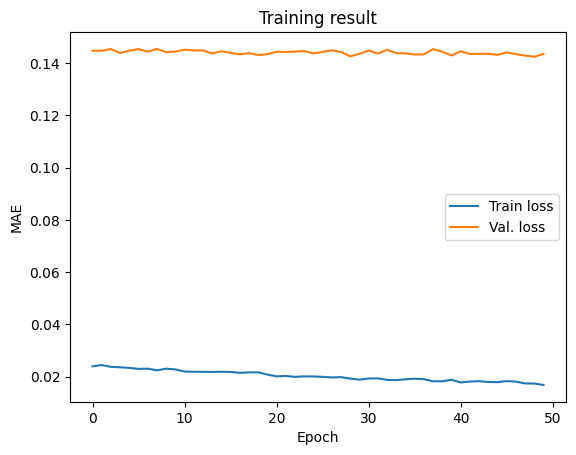

In [35]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train loss')
ax.plot(val_losses, label='Val. loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MAE')
plt.title("Training result")
plt.legend()

# Testing

In [36]:
model.eval()
with torch.no_grad():
    batch_loss_ext = []
    batch_loss_neu = []
    batch_loss_agr = []
    batch_loss_con = []
    batch_loss_ope = []

    batch_r_ext = []
    batch_r_neu = []
    batch_r_agr = []
    batch_r_con = []
    batch_r_ope = []

    h = model.init_hidden(BATCH_SIZE)

    for inputs, targets in test_loader:
        model.eval()
        h = h.data
        preds, h = model(inputs.to(device), h)
        
        loss_ext = loss_fn(preds[:,0], targets[:,0].to(device))
        loss_neu = loss_fn(preds[:,1], targets[:,1].to(device))
        loss_agr = loss_fn(preds[:,2], targets[:,2].to(device))
        loss_con = loss_fn(preds[:,3], targets[:,3].to(device))
        loss_ope = loss_fn(preds[:,4], targets[:,4].to(device))
        batch_loss_ext.append(loss_ext.item())
        batch_loss_neu.append(loss_neu.item())
        batch_loss_agr.append(loss_agr.item())
        batch_loss_con.append(loss_con.item())
        batch_loss_ope.append(loss_ope.item())
        
        r_ext = pearsonr(preds.cpu()[:,0], targets[:,0])
        r_neu = pearsonr(preds.cpu()[:,1], targets[:,1])
        r_agr = pearsonr(preds.cpu()[:,2], targets[:,2])
        r_con = pearsonr(preds.cpu()[:,3], targets[:,3])
        r_ope = pearsonr(preds.cpu()[:,4], targets[:,4])
        batch_r_ext.append(r_ext)
        batch_r_neu.append(r_neu)
        batch_r_agr.append(r_agr)
        batch_r_con.append(r_con)
        batch_r_ope.append(r_ope)
        
    loss_ext = 1 - np.mean(batch_loss_ext)
    loss_neu = 1 - np.mean(batch_loss_neu)
    loss_agr = 1 - np.mean(batch_loss_agr)
    loss_con = 1 - np.mean(batch_loss_con)
    loss_ope = 1 - np.mean(batch_loss_ope)
    loss = (loss_ext + loss_neu + loss_agr + loss_con + loss_ope) / 5
    
    r_ext = np.array(batch_r_ext)[:,0].mean()
    r_neu = np.array(batch_r_neu)[:,0].mean()
    r_agr = np.array(batch_r_agr)[:,0].mean()
    r_con = np.array(batch_r_con)[:,0].mean()
    r_ope = np.array(batch_r_ope)[:,0].mean()
    r = (r_ext + r_neu + r_agr + r_con + r_ope) / 5
    
    print(f'1-MAE: {loss}')
    print(f'1-MAE Extraversion: {loss_ext}')
    print(f'1-MAE Neuroticism: {loss_ext}')
    print(f'1-MAE Agreeableness: {loss_ext}')
    print(f'1-MAE Conscientiousness: {loss_ext}')
    print(f'1-MAE Openness: {loss_ext}')
    print(f'r_extraversion: {r_ext}')
    print(f'r_neuroticism: {r_neu}')
    print(f'r_agreeableness: {r_agr}')
    print(f'r_conscientiousness: {r_con}')
    print(f'r_openness: {r_ope}')
    print(f'r: {r}')

1-MAE: 0.8550812472899756
1-MAE Extraversion: 0.8593817055225372
1-MAE Neuroticism: 0.8593817055225372
1-MAE Agreeableness: 0.8593817055225372
1-MAE Conscientiousness: 0.8593817055225372
1-MAE Openness: 0.8593817055225372
r_extraversion: 0.021465201839690102
r_neuroticism: 0.0281750645018133
r_agreeableness: -0.014989927758485396
r_conscientiousness: -0.015699596227086155
r_openness: -0.004973076593139511
r: 0.002795533152558466
